In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor 
from sklearn.preprocessing import StandardScaler
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json


from utils.helper_functions import split_data
from utils.helper_functions import get_features_and_target

In [3]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))

/home/sammibulin/miniforge3/envs/DL/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
train_df, val_df, test_df = split_data(cancer_df)

In [5]:
train_df.loc[:, numeric_cols] = scaler.transform(train_df[numeric_cols])
val_df.loc[:, numeric_cols] = scaler.transform(val_df[numeric_cols])
test_df.loc[:, numeric_cols] = scaler.transform(test_df[numeric_cols])

In [6]:
X_train, y_train = get_features_and_target(train_df)
X_val, y_val = get_features_and_target(val_df)
X_test, y_test = get_features_and_target(test_df)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((558, 203), (558,), (186, 203), (186,), (187, 203), (187,))

In [ ]:
def gbm_objective_pipeline_noy_scale_only(trial): # Renamed for clarity
    gbm_params = {
        "regressor__gbm__n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "regressor__gbm__learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.01),
        "regressor__gbm__max_depth": trial.suggest_int("max_depth", 10, 25),
        "regressor__gbm__min_samples_split": trial.suggest_int("min_samples_split", 4, 25),
        "regressor__gbm__min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 25),
        "regressor__gbm__subsample": trial.suggest_float("subsample", 0.75, 1.0),
        "regressor__gbm__max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        # Add random_state to the inner GBM if needed
        "regressor__gbm__random_state": 29
    }

    # --- Create the necessary instances INSIDE the objective ---
    y_scaler = StandardScaler() # Scaler for target (y)
    inner_gbm_regressor = GradientBoostingRegressor() # Base GBM

    # --- Create the INNER Pipeline (ONLY the GBM step) ---
    # This pipeline takes X as input and passes it directly to GBM.
    # It does NOT contain an X scaler.
    inner_pipeline = Pipeline([
        ('gbm', inner_gbm_regressor) # Step 1: GBM Regressor (name matches param prefix)
                                     # No 'scaler_x' step here!
    ])

    # --- Create the OUTER TransformedTargetRegressor ---
    # This wraps the inner_pipeline and applies y_scaler to the target
    model = TransformedTargetRegressor(
        regressor=inner_pipeline, # The Pipeline (with only GBM) is the regressor being wrapped
        transformer=y_scaler      # The scaler for the target variable y
    )

    # --- Set the hyperparameters ---
    # Nested parameters like 'regressor__gbm__n_estimators' are correctly routed
    model.set_params(**gbm_params)

    # --- Train the combined model ---
    try:
        # Outer TTR fits y_scaler on y_train & calls inner_pipeline.fit(X_train, scaled_y_train)
        # Inner Pipeline calls gbm.fit(X_train, scaled_y_train) (since no X scaler)
        model.fit(X_train, y_train) # Pass original X_train, y_train
    except Exception as e:
        print(f"Trial {trial.number} failed during fit: {e}")
        return float('inf')

    # --- Evaluate the model ---
    try:
        # Outer TTR calls inner_pipeline.predict(X_val) -> returns scaled_y_pred
        # Inner Pipeline calls gbm.predict(X_val) -> scaled_y_pred
        # Outer TTR calls y_scaler.inverse_transform(scaled_y_pred) -> final y_pred
        y_pred = model.predict(X_val) # Predictions are automatically inverse-transformed

        # Calculate MSE on the original y scale
        mse = mean_squared_error(y_val, y_pred)
    except Exception as e:
        print(f"Trial {trial.number} failed during predict/eval: {e}")
        return float('inf')

    return mse

# Use Optuna for hyperparameter search
gbm_study = optuna.create_study(direction="minimize", study_name="GBM_PipelineNoX_ScaleY")
gbm_study.optimize(gbm_objective_pipeline_noy_scale_only, n_trials=50, n_jobs=-1)


[I 2025-04-14 15:41:50,694] A new study created in memory with name: GBM_PipelineNoX_ScaleY


Starting Optuna optimization (Pipeline for GBM, Scaling Y)...


[I 2025-04-14 15:41:52,944] Trial 7 finished with value: 953.2523966740118 and parameters: {'n_estimators': 100, 'learning_rate': 0.25, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 5, 'subsample': 0.9826785567482161, 'max_features': 'sqrt'}. Best is trial 7 with value: 953.2523966740118.
[I 2025-04-14 15:41:55,390] Trial 3 finished with value: 1008.5225348048737 and parameters: {'n_estimators': 250, 'learning_rate': 0.29000000000000004, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 16, 'subsample': 0.8415943017394321, 'max_features': 'log2'}. Best is trial 7 with value: 953.2523966740118.
[I 2025-04-14 15:41:56,189] Trial 5 finished with value: 768.9870020880256 and parameters: {'n_estimators': 300, 'learning_rate': 0.04, 'max_depth': 12, 'min_samples_split': 24, 'min_samples_leaf': 25, 'subsample': 0.8678461195687712, 'max_features': 'sqrt'}. Best is trial 5 with value: 768.9870020880256.
[I 2025-04-14 15:41:59,049] Trial 8 finished with value: 895.774

Optimization finished.


Best Hyperparameters found by Optuna:
{
    "n_estimators": 200,
    "learning_rate": 0.01,
    "max_depth": 12,
    "min_samples_split": 5,
    "min_samples_leaf": 12,
    "subsample": 0.823834209338248,
    "max_features": "sqrt"
}
Retraining complete.

Making predictions on validation data (X_test)...

Final Model Performance on the Test Set:
  Mean Squared Error (MSE): 473.4164
  R-squared (R2):         -0.1275
  Mean Absolute Error (MAE):17.7548

Generating Actual vs. Predicted scatterplot...


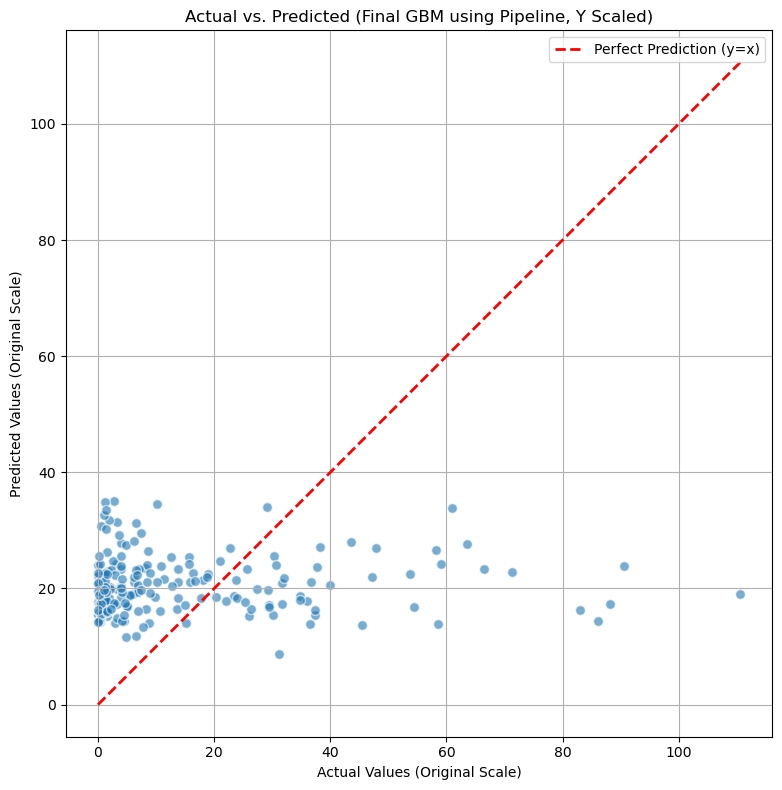

Plot displayed.


In [16]:
# 1. Get the Best Hyperparameters from Optuna
best_params = gbm_study.best_params 
print("Best Hyperparameters found by Optuna:")
print(json.dumps(best_params, indent=4))

# 2. Create the Final Model with the *SAME* Nested Structure
final_y_scaler = StandardScaler()
final_gbm = GradientBoostingRegressor() # Base instance

# Create the inner pipeline structure (ONLY GBM)
final_inner_pipeline = Pipeline([
    ('gbm', final_gbm)
])

# Create the outer TransformedTargetRegressor structure
final_model = TransformedTargetRegressor(
    regressor=final_inner_pipeline, # Wrap the simple pipeline
    transformer=final_y_scaler      # Use the y scaler
)


# Manually add prefixes to the parameters
best_params_prefixed = {}
for key, value in best_params.items():
    # Add the prefix needed for TransformedTargetRegressor -> Pipeline -> GBM
    new_key = f"regressor__gbm__{key}"
    best_params_prefixed[new_key] = value


with open("results/gbm_best_params.json", "w") as f:
    json.dump(best_params_prefixed, f, indent=4)


# Handles the nested 'regressor__gbm__...' parameters
final_model.set_params(**best_params_prefixed)

# fitting gbm on X_train and scaled_y_train
final_model.fit(X_train, y_train)
print("Retraining complete.")

# 5. Make Predictions on the Test Set
print(f"\nMaking predictions on validation data (X_test)...")
# Handles predicting scaled_y, and inverse-transforming y
y_pred_final = final_model.predict(X_test)
y_true_final = y_test

# 6. Evaluate the Final Model's Performance (on original y scale)
final_mse = mean_squared_error(y_true_final, y_pred_final)
final_r2 = r2_score(y_true_final, y_pred_final)
final_mae = mean_absolute_error(y_true_final, y_pred_final)

print("\nFinal Model Performance on the Test Set:")
print(f"  Mean Squared Error (MSE): {final_mse:.4f}")
print(f"  R-squared (R2):         {final_r2:.4f}")
print(f"  Mean Absolute Error (MAE):{final_mae:.4f}")

# 7. Create the Scatterplot (using original scale values)
print("\nGenerating Actual vs. Predicted scatterplot...")
plt.figure(figsize=(8, 8))
plt.scatter(y_true_final, y_pred_final, alpha=0.6, edgecolors='w', s=50)
plt.xlabel("Actual Values (Original Scale)")
plt.ylabel("Predicted Values (Original Scale)")
plt.title("Actual vs. Predicted (Final GBM using Pipeline, Y Scaled)")

min_val = min(np.min(y_true_final), np.min(y_pred_final))
max_val = max(np.max(y_true_final), np.max(y_pred_final))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')

plt.grid(True)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()
print("Plot displayed.")

In [7]:
# Generate Regressor
gbm_reg = GradientBoostingRegressor(random_state = 29)

*Define Optuna Search Space*

In [ ]:
def gbm_objective(trial):
    gbm_params = {
        "gbm__n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "gbm__learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.01),
        "gbm__max_depth": trial.suggest_int("max_depth", 10, 25), # Your original depth range
        "gbm__min_samples_split": trial.suggest_int("min_samples_split", 4, 25), # Your original split range
        "gbm__min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 25), # Your original leaf range
        "gbm__subsample": trial.suggest_float("subsample", 0.75, 1.0), # Your original subsample range
        "gbm__max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
    }

    # Initiate the model
    gbm_pipeline = Pipeline([
        ('gbm', GradientBoostingRegressor(random_state=29))
    ])
    gbm_pipeline.set_params(**gbm_params)
    #GradientBoostingRegressor(random_state=29, **params)

    # Train the model
    gbm_pipeline.fit(X_train, y_train)

    # Evaluate the model
    y_pred = gbm_pipeline.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    return mse

*Run Optuna*

In [ ]:
gbm_study = optuna.create_study(direction = "minimize", study_name = "GBM_Regressor")
gbm_study.optimize(gbm_objective, n_trials = 50, n_jobs = -1)

# Save the best model
best_params = gbm_study.best_params
with open("results/gbm_best_params.json", "w") as f:
    json.dump(best_params, f, indent=4)

In [ ]:
best_params

{'n_estimators': 100,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_samples_split': 17,
 'min_samples_leaf': 1,
 'subsample': 0.7574861651419491,
 'max_features': 'sqrt'}

In [ ]:
# Rename output keys to operate with sklearn pipeline
old_keys = list(best_params.keys())
for key in old_keys:
    new_key = "gbm__" + key
    best_params[new_key] = best_params.pop(key)

# Train the best model on the full training set
gbm_pipeline = Pipeline([
    ('gbm', GradientBoostingRegressor(random_state=29))
])
gbm_pipeline.set_params(**best_params)
gbm_pipeline.fit(X_train, y_train)


Pipeline(steps=[('gbm',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                           max_features='sqrt',
                                           min_samples_split=17,
                                           random_state=29,
                                           subsample=0.7574861651419491))])

In [ ]:
# If using a separate test set, use X_test here
y_pred_final = gbm_pipeline.predict(X_test)
# Assign the corresponding true values
y_true_final = y_test # Or y_test

# 6. Evaluate the Final Model's Performance
final_mse = mean_squared_error(y_true_final, y_pred_final)
final_r2 = r2_score(y_true_final, y_pred_final)
final_mae = mean_absolute_error(y_true_final, y_pred_final)

print("\nFinal Model Performance on Validation/Test Set:")
print(f"  Mean Squared Error (MSE): {final_mse:.4f}")
print(f"  R-squared (R2):         {final_r2:.4f}")
print(f"  Mean Absolute Error (MAE):{final_mae:.4f}")


Final Model Performance on Validation/Test Set:
  Mean Squared Error (MSE): 469.0818
  R-squared (R2):         -0.1172
  Mean Absolute Error (MAE):17.7408


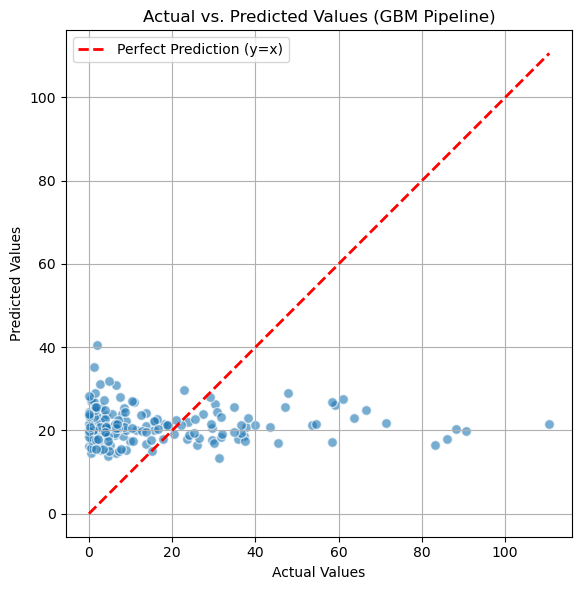

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true_final, y_pred_final, alpha=0.6, edgecolors='w', s=50) # Added some styling
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (GBM Pipeline)")

# Add a line for perfect correlation (y=x)
min_val = min(np.min(y_true_final), np.min(y_pred_final))
max_val = max(np.max(y_true_final), np.max(y_pred_final))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')

plt.grid(True)
plt.legend()
# Ensure aspect ratio is equal if desired, helps visualize deviations from y=x
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()